In [1]:
import os 

import azureml.core
from azureml.core import Workspace, Dataset, Datastore, Experiment, Environment, ScriptRunConfig
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException
#from azureml.core.runconfig import PyTorchConfiguration
from azureml.core.runconfig import PyTorchConfiguration, DockerConfiguration
from azureml.core.conda_dependencies import CondaDependencies

from azureml.data import OutputFileDatasetConfig
from azureml.telemetry import set_diagnostics_collection

from azureml.widgets import RunDetails

set_diagnostics_collection(send_diagnostics=True)

print("SDK version:", azureml.core.VERSION)

Turning diagnostics collection on. 
SDK version: 1.38.0


In [2]:
azureml._restclient.snapshots_client.SNAPSHOT_MAX_SIZE_BYTES = 2000000000

In [3]:
project_folder = '../dino'


In [4]:
ws = Workspace.from_config()
datastore = ws.get_default_datastore()
image_net_dataset = Dataset.get_by_name(ws, 'imagenet_2015_premium_west_full')

In [7]:
# choose a name for your cluster
cluster_name = 'A100-8x2'
try:
    compute_target = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing compute target.')
except ComputeTargetException:
    print('Cannot Find the compute cluster')

# use get_status() to get a detailed status for the current AmlCompute. 
print(compute_target.get_status().serialize())

Found existing compute target.
{'currentNodeCount': 1, 'targetNodeCount': 1, 'nodeStateCounts': {'preparingNodeCount': 0, 'runningNodeCount': 1, 'idleNodeCount': 0, 'unusableNodeCount': 0, 'leavingNodeCount': 0, 'preemptedNodeCount': 0}, 'allocationState': 'Steady', 'allocationStateTransitionTime': '2022-03-07T17:26:59.114000+00:00', 'errors': None, 'creationTime': '2022-03-03T17:35:34.717374+00:00', 'modifiedTime': '2022-03-06T10:41:47.006129+00:00', 'provisioningState': 'Succeeded', 'provisioningStateTransitionTime': None, 'scaleSettings': {'minNodeCount': 0, 'maxNodeCount': 2, 'nodeIdleTimeBeforeScaleDown': 'PT30S'}, 'vmPriority': 'Dedicated', 'vmSize': 'STANDARD_ND96AMSR_A100_V4'}


In [8]:
#pytorch_env = Environment.from_conda_specification(name='AzureML-PyTorch-1.6-GPU',file_path='distributed-pytorch-with-distributeddataparallel.yml')
curated_env_name = 'AzureML-pytorch-1.10-ubuntu18.04-py38-cuda11-gpu'
pytorch_env = Environment.get(workspace=ws, name=curated_env_name)
pytorch_env.environment_variables = {"AZUREML_DOWNLOAD_CONCURRENCY":384} 

dino_env = pytorch_env.clone("dino_env")

conda = CondaDependencies()

# # add pip packages
conda.add_pip_package('timm')
# # create environment
dino_env.python.conda_dependencies = conda
docker_config = DockerConfiguration(use_docker=True, arguments = ['--ipc=host'], shm_size='1024g')




Property environment_variables is deprecated. Use RunConfiguration.environment_variables to set runtime variables.


In [17]:
patch_size = 16
batch_size_per_gpu = 128
node_count = 1
process_count = 8
communication_backend = 'NCCL'

In [16]:
#datastore = ws.get_default_datastore()
#out_dataset = Dataset.get_by_name(ws,name='Output_node1_ViTs_gpus8_bacthsize64')


In [10]:
output_folder = 'Output_Inference_node'+str(node_count)+'_'+'ViTs_gpus'+str(process_count)+'_bacthsize'+str(batch_size_per_gpu)

output= OutputFileDatasetConfig(destination=(datastore, output_folder))

In [11]:
output_folder 

'Output_Inference_node1_ViTs_gpus8_bacthsize64'

# Inference - Linear

from azureml.core import Experiment
experiment_name = 'exp_Inference_ViTS16'
Inference_experiment = Experiment(ws, name=experiment_name)
# create distributed config
distr_Inference_config = PyTorchConfiguration(node_count=node_count)
launch_cmd = ["python -m torch.distributed.launch --nproc_per_node=8 eval_linear.py --pretrained_weights",'./checkpoints' , "--checkpoint_key teacher  --data_path", image_net_dataset.as_download(),"--patch_size ", str(patch_size), "--batch_size_per_gpu ",str(batch_size_per_gpu),"--node_rank $NODE_RANK --master_addr $MASTER_ADDR --master_port $MASTER_PORT --use_env --output_dir ",output.as_mount()]
#launch_cmd = ["torchrun eval_linear.py --nproc_per_node 8 --pretrained_weights",'./checkpoints' , "--checkpoint_key teacher --data_path", image_net_dataset.as_download(),"--patch_size ", str(patch_size), "--batch_size_per_gpu ",str(batch_size_per_gpu),"\
#"--output_dir",output.as_mount()]

src_config_linear = ScriptRunConfig(
  source_directory=project_folder,
  command=launch_cmd,
  compute_target=compute_target,
  environment=dino_env,
  distributed_job_config=distr_Inference_config
)
runInferenceLinear = Inference_experiment.submit(src_config_linear)

In [21]:
from azureml.core import Experiment
experiment_name = 'exp_Inference_ViTS16'
Inference_experiment = Experiment(ws, name=experiment_name)
distr_config = PyTorchConfiguration(process_count=8, node_count=1)

# create args

args = ["--pretrained_weights",'./checkpoints' , 
        "--checkpoint_key", 'teacher',
        "--data_path", image_net_dataset.as_download()#,
       # "--output_dir ",output.as_mount()
        ]

# create job config
src = ScriptRunConfig(
    source_directory=project_folder,
    script='eval_linear.py',
    arguments=args,
    compute_target=compute_target,
    environment=dino_env,
    distributed_job_config=distr_config
)
runInferenceLinear = Inference_experiment.submit(src)

Submitting /mnt/batch/tasks/shared/LS_root/mounts/clusters/ds3-4cores/code/Users/aghasemi/dino directory for run. The size of the directory >= 25 MB, so it can take a few minutes.


In [22]:
runInferenceLinear.tag("author","AFS")
runInferenceLinear.tag("storage" , "premium")
runInferenceLinear.tag("envoirnment" ,'dino_env' )
runInferenceLinear.tag("dataset", "download")
runInferenceLinear.tag("batch_size_per_gpu" , str(batch_size_per_gpu))
runInferenceLinear.tag("patch_size" , str(patch_size))
runInferenceLinear.tag("epochs" , "100")
runInferenceLinear.tag("ENV" , str(curated_env_name))
runInferenceLinear.tag("gpus" , str(process_count))
runInferenceLinear.tag("nodes" , str(node_count))
runInferenceLinear.tag("comment" , "removed evaluate+ data parallel for model added in utils+nproc added+fixed linear load of pretrained weight")


In [23]:
from azureml.widgets import RunDetails

RunDetails(runInferenceLinear).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': True, 'log_level': 'INFO', 's…

# Visualise attention

In [13]:
%run visualize_attention --pretrained_weights 'checkpoint.pth' --checkpoint_key 'teacher' --image_path 'img.png' --patch_size 16

Take key teacher in provided checkpoint dict
Pretrained weights found at checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])
./attn-head0.png saved.
./attn-head1.png saved.
./attn-head2.png saved.
./attn-head3.png saved.
./attn-head4.png saved.
./attn-head5.png saved.


/anaconda/envs/azureml_py36/lib/python3.6/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


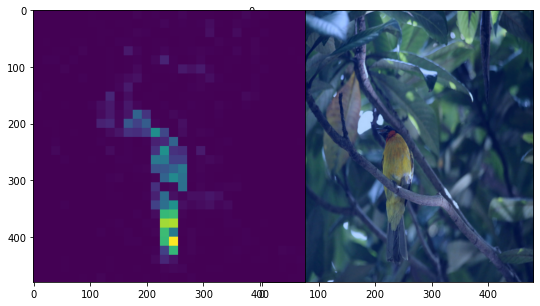

In [14]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15, 5))
fig.add_subplot(1, 1, 1)
img = plt.imread('img.png')
plt.imshow(img)
fig.add_subplot(1, 2, 1)
attn = plt.imread('attn-head0.png')
plt.imshow(attn)
plt.show()